# Software Vulnerability Detection using Deep Learning (Experiment Replication)

### Single column experiment (CWE-119)

* This is from Russell et. al work (Automated Vulnerability Detection in Source Code Using Deep Representation Learning) https://arxiv.org/abs/1807.04320
* Datasets downloaded from https://osf.io/d45bw/
* Datasets distribution: Training (80%), Validation (10%), Testing (10%)
* The dataset consists of the source code of 1.27 million functions mined from open source software, labeled by static analysis for potential vulnerabilities.
* Each function's raw source code, starting from the function name, is stored as a variable-length UTF-8 string. Five binary 'vulnerability' labels are provided for each function, corresponding to the four most common CWEs in our data plus all others: 
 * CWE-120 (3.7% of functions)
 * CWE-119 (1.9% of functions)
 * CWE-469 (0.95% of functions)
 * CWE-476 (0.21% of functions)
 * CWE-other (2.7% of functions)
* Functions may have more than one detected CWE each.
* Python 3.6 and Tensorflow 2.0.0

## Pre-processing

Converting the HDF5 files for training/validation/testing datasets to python pickle for ease of future usage

In [9]:
import h5py
import pandas as pd

In [15]:
# 3 datasets available

data = h5py.File("VDISC_train.hdf5",'r')
#data = h5py.File("VDISC_validate.hdf5",'r')
#data = h5py.File("VDISC_test.hdf5",'r')

In [30]:
# List all groups
data.visit(print)

CWE-119
CWE-120
CWE-469
CWE-476
CWE-other
functionSource


Create a new dataframe from the HDF5 file

In [16]:
mydf = pd.DataFrame(list(data['functionSource']))

In [17]:
mydf['CWE-119']=list(data['CWE-119']); mydf['CWE-120']=list(data['CWE-120']); mydf['CWE-469']=list(data['CWE-469']); mydf['CWE-476']=list(data['CWE-476']); mydf['CWE-other']=list(data['CWE-other']) 

In [18]:
mydf.rename(columns={0:'functionSource'},inplace=True)

In [71]:
mydf.iloc[0:5,0:]

,functionSource,CWE-119,CWE-120,CWE-469,CWE-476,CWE-other
0,"clear_area(int startx, int starty, int xsize, ...",False,False,False,False,False
1,ReconstructDuList(Statement* head)\n{\n Sta...,False,False,False,False,False
2,free_speaker(void)\n{\n if(Lengths)\n ...,False,False,False,False,False
3,mlx4_register_device(struct mlx4_dev *dev)\n{\...,False,False,False,False,False
4,"Parse_Env_Var(void)\n{\n char *p = getenv(""LI...",True,True,False,False,True


In [19]:
mydf.to_pickle("VDISC_train.pickle")
#mydf.to_pickle("VDISC_validate.pickle")
#mydf.to_pickle("VDISC_test.pickle")

## Learning Phase

### Importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import pickle

print("Tensorlfow version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensorlfow version:  2.0.0
Eager mode:  True
GPU is available


### Setting static and global variables

In [2]:
# Generate random seed
#myrand=np.random.randint(1, 99999 + 1)
myrand=71926
np.random.seed(myrand)
tf.random.set_seed(myrand)
print("Random seed is:",myrand)

Random seed is: 71926


In [3]:
# Set the global value
WORDS_SIZE=10000
INPUT_SIZE=500
NUM_CLASSES=2
MODEL_NUM=0
EPOCHS=10

### Importing processed datasets

In [4]:
train=pd.read_pickle("newtrain.pickle")
validate=pd.read_pickle("newval.pickle")
test=pd.read_pickle("newtest.pickle")

for dataset in [train,validate,test]:
    dataset.iloc[:,6] = dataset.iloc[:,6].map({False: 0, True: 1})

# Create source code sdata for tokenization
x_all = train['functionSource']
#x_all = x_all.append(validate['functionSource'])
#x_all = x_all.append(test['functionSource'])

### Tokenizing the source codes

In [5]:
# Tokenizer with word-level
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=False)
tokenizer.fit_on_texts(list(x_all))
del(x_all)
print('Number of tokens: ',len(tokenizer.word_counts))

Number of tokens:  1094129


In [6]:
# Reducing to top N words
tokenizer.num_words = WORDS_SIZE

In [9]:
# Top 10 words
sorted(tokenizer.word_counts.items(), key=lambda x:x[1], reverse=True)[0:10]

[('if', 3908040),
 ('0', 2633095),
 ('return', 2182544),
 ('i', 1720280),
 ('1', 1483872),
 ('int', 1271988),
 ('null', 1222633),
 ('the', 990541),
 ('t', 917046),
 ('n', 892342)]

### Create sequence files from the tokens

In [7]:
## Tokkenizing train data and create matrix
list_tokenized_train = tokenizer.texts_to_sequences(train['functionSource'])
x_train = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_train, 
                                  maxlen=INPUT_SIZE,
                                  padding='post')
x_train = x_train.astype(np.int64)

In [8]:
## Tokkenizing test data and create matrix
list_tokenized_test = tokenizer.texts_to_sequences(test['functionSource'])
x_test = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_test, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_test = x_test.astype(np.int64)

In [9]:
## Tokkenizing validate data and create matrix
list_tokenized_validate = tokenizer.texts_to_sequences(validate['functionSource'])
x_validate = tf.keras.preprocessing.sequence.pad_sequences(list_tokenized_validate, 
                                 maxlen=INPUT_SIZE,
                                 padding='post')
x_validate = x_validate.astype(np.int64)

### Model Definition (CNN with Gaussian Noise and 1 Output Split)

In [10]:
# Create a random weights matrix

random_weights = np.random.normal(size=(WORDS_SIZE, 13),scale=0.01)

In [11]:
# Must use non-sequential model building to create branches in the output layer
model = tf.keras.Sequential(name="CNN")
model.add(tf.keras.layers.Embedding(input_dim = WORDS_SIZE,
                                    output_dim = 13,
                                    weights=[random_weights],
                                    input_length = INPUT_SIZE))
#model.add(tf.keras.layers.GaussianNoise(stddev=0.01))
model.add(tf.keras.layers.Convolution1D(filters=512, kernel_size=(9), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPool1D(pool_size=4))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Define custom optimizers
adam = tf.keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1, decay=0.0, amsgrad=False)

## Compile model with metrics
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
print("CNN model built: ")
model.summary()

CNN model built: 
Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 13)           130000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 512)          60416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 125, 512)          0         
_________________________________________________________________
dropout (Dropout)            (None, 125, 512)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64000)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4096064   
_________________________________________________________________
dense_1 (Dense)              (None, 16)      

### Tensorboard Callbacks

In [12]:
## Create TensorBoard callbacks

callbackdir= 'D:\\temp\\cb'

tbCallback = tf.keras.callbacks.TensorBoard(log_dir=callbackdir, 
                         histogram_freq=1,
                         embeddings_freq=1,
                         write_graph=True, 
                         write_images=True)

tbCallback.set_model(model)
mld = 'model/model-COMB-{epoch:02d}-single.hdf5'

## Create best model callback
mcp = tf.keras.callbacks.ModelCheckpoint(filepath=mld, 
                                         monitor="val_loss",
                                         save_best_only=True, 
                                         mode='auto', 
                                         save_freq='epoch', 
                                         verbose=1)

### Model Training

In [13]:
class_weights = {0: 1., 1: 3.}

history = model.fit(x = x_train,
          y = train.iloc[:,6].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,6].to_numpy()),
          epochs = 30,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch30-COMB', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Train on 1019471 samples, validate on 127476 samples
Epoch 1/30

Epoch 00001: val_loss improved from inf to 0.48608, saving model to model/model-COMB-01-single.hdf5
1019471/1019471 - 171s - loss: 0.5024 - accuracy: 0.9348 - val_loss: 0.4861 - val_accuracy: 0.9353
Epoch 2/30

Epoch 00002: val_loss improved from 0.48608 to 0.42399, saving model to model/model-COMB-02-single.hdf5
1019471/1019471 - 166s - loss: 0.4563 - accuracy: 0.9288 - val_loss: 0.4240 - val_accuracy: 0.9193
Epoch 3/30

Epoch 00003: val_loss improved from 0.42399 to 0.40203, saving model to model/model-COMB-03-single.hdf5
1019471/1019471 - 166s - loss: 0.4122 - accuracy: 0.9161 - val_loss: 0.4020 - val_accuracy: 0.9176
Epoch 4/30

Epoch 00004: val_loss improved from 0.40203 to 0.38034, saving model to model/model-COMB-04-single.hdf5
1019471/1019471 - 166s - loss: 0.3900 - accuracy: 0.9135 - val_loss: 0.3803 - val_accuracy: 0.9121
Epoch 5/30

Epoch 00005: val_loss improved from 0.38034 to 0.36831, saving model to model/m

### Code to Continue Training (Optional)

In [ ]:
# Continue training for another 100 epochs

history40 = model.fit(x = x_train,
          y = train.iloc[:,6].to_numpy(),
          validation_data = (x_validate, validate.iloc[:,6].to_numpy()),
          epochs = 20,
          batch_size = 128,
          verbose =2,
          class_weight= class_weights,
          callbacks=[mcp,tbCallback])

with open('history/history-Epoch40-CNN-single', 'wb') as file_pi:
    pickle.dump(history40.history, file_pi)


### Load the model

In [14]:
# Load model
model = tf.keras.models.load_model("model/model-COMB-30-single.hdf5")

### Model Evaluation using Training Set

In [ ]:
results = model.evaluate(x_train[[*one,*zero[0:ceiling]],:], train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), verbose=0, batch_size=128, )
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_train[[*one,*zero[0:ceiling]],:])
predicted_prob = model.predict(x_train[[*one,*zero[0:ceiling]],:])

print('\nConfusion Matrix')
#predicted = model.predict_classes(x_test)
confusion = sklearn.metrics.confusion_matrix(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)
print(confusion)

tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_score=predicted_prob)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_score=predicted_prob)))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=train.iloc[[*one,*zero[0:ceiling]],1].to_numpy(), y_pred=predicted)))

### Model Evaluation using Testing Set

In [15]:
## Test data

results = model.evaluate(x_test, test.iloc[:,6].to_numpy(), batch_size=128)
for num in range(0,len(model.metrics_names)):
    print(model.metrics_names[num]+': '+str(results[num]))

predicted = model.predict_classes(x_test)
predicted_prob = model.predict(x_test)

confusion = sklearn.metrics.confusion_matrix(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)
print(confusion)
tn, fp, fn, tp = confusion.ravel()
print('\nTP:',tp)
print('FP:',fp)
print('TN:',tn)
print('FN:',fn)

## Performance measure
print('\nAccuracy: '+ str(sklearn.metrics.accuracy_score(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)))
print('Precision: '+ str(sklearn.metrics.precision_score(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)))
print('Recall: '+ str(sklearn.metrics.recall_score(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)))
print('F-measure: '+ str(sklearn.metrics.f1_score(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)))
print('Precision-Recall AUC: '+ str(sklearn.metrics.average_precision_score(y_true=test.iloc[:,6].to_numpy(), y_score=predicted_prob)))
print('AUC: '+ str(sklearn.metrics.roc_auc_score(y_true=test.iloc[:,6].to_numpy(), y_score=predicted_prob)))
print('MCC: '+ str(sklearn.metrics.matthews_corrcoef(y_true=test.iloc[:,6].to_numpy(), y_pred=predicted)))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



loss: 0.20374799665427878
accuracy: 0.9071881
[[110500   8666]
 [  3160   5093]]

TP: 5093
FP: 8666
TN: 110500
FN: 3160

Accuracy: 0.9071880959668496
Precision: 0.3701577149502144
Recall: 0.6171089300860293
F-measure: 0.4627475922224241
Precision-Recall AUC: 0.36650726158948616
AUC: 0.8830663434591075
MCC: 0.4317103534745538


### Plot The Model's Training History

In [18]:
model.metrics_names

['loss', 'accuracy']

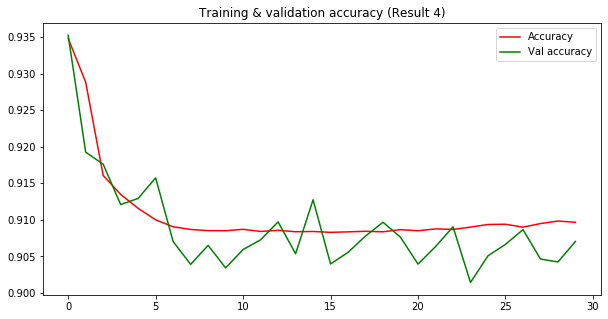

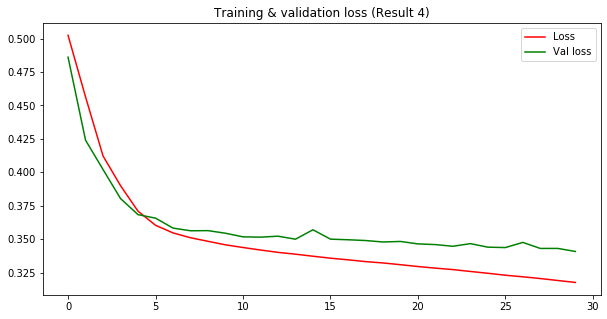

In [22]:
epochs_range = range(len(history.history[model.metrics_names[1]]))


plt.figure(figsize=(10,5))
plt.plot(epochs_range, history.history[(model.metrics_names[1])], 'b', label='Accuracy', color='red')
plt.plot(epochs_range, history.history['val_%s'%(model.metrics_names[1])], 'b', label='Val accuracy', color='green')
plt.title('Training & validation accuracy (Result 4)')
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(epochs_range, history.history[model.metrics_names[0]], 'b', label='Loss', color='red')
plt.plot(epochs_range, history.history['val_%s'%model.metrics_names[0]], 'b', label='Val loss', color='green')
plt.title('Training & validation loss (Result 4)')
plt.legend()



## Table (Testing set results only)

The results are as below (30 epochs unless stated):

| No.| Learning_Rate|MaxPool|Weights (0 : 1)|TP|FP|TN|FN|Acc|Precision|Recall|PR-AUC|AUC|MCC|F1|
|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|---	|
|  1	|  0.005|  4	| 1 : 5|  5817 	|  11376  	| 107790  	|2436| 0.8916  	|  0.3383 	| 0.7048  	| 0.3858| 0.8871|0.4389| 0.4572|
|  2	| 0.0005|  4	| 1 : 5|  4668 	|  9702  	| 109464  	|3585| 0.8957  	|  0.3248 	| 0.5656  	| 0.3172| 0.8595|0.3767| 0.4126|
|  3	| 0.005 |  5	| 1 : 5|  5924 	|  12066  	| 107100  	|2329| 0.8870  	|  0.3292 	| 0.7177  	| 0.3761| 0.8866|0.4357| 0.4514|
|  4	| 0.005 |  4	| 1 : 3|  5093 	|  8666  	| 110500  	|3160| 0.9071  	|  0.3701 	| 0.6171  	| 0.3665| 0.8830|0.4317| 0.4627|

